In [1]:
import nltk
import numpy as np
from nltk.corpus import genesis
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [2]:
"""
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('genesis')

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
"""

"\nnltk.download('stopwords')\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('genesis')\n\nnltk.download('punkt_tab')\nnltk.download('averaged_perceptron_tagger_eng')\nnltk.download('averaged_perceptron_tagger')\nnltk.download('vader_lexicon')\n"

In [3]:
import pandas as pd

path = "./kurrek.2020.slur-corpus.csv"
data = pd.read_csv(path, sep=",", header = 0, on_bad_lines='skip')

In [4]:
# Make function to check if string contains any element from a string
# https://bobbyhadz.com/blog/python-check-if-string-contains-element-from-list
def is_element_in_string(string, flist):
    if any((match := substring) in string for substring in flist):
        print('The string contains at least one element from the list')
    return match

In [5]:
# Replace slur with [REDACTED], and print
# Make new data list using pandas
# This one is only to print the strings, to avoid printing harmful language. 

path = "./kurrek.2020.slur-corpus.csv"
redacted_data = pd.read_csv(path, sep=",", header = 0, on_bad_lines='skip')

# Iterate for each index in redacted_data, and modify the 'body' to replace the 
# slur with [REDACTED]. The indexes will remain the same as the one found in the original
# document, so this is really to just print out certain rows whilst avoiding printing out the
# harmful language (the slurs).
for index, row in redacted_data.iterrows():
    T1, T2 = str(row['body']), str(row['slur'])
    redacted_data.at[index, 'body'] = T1.lower().replace(T2, "[REDACTED]")

## Task 1

In [6]:
"""By constructing a dataframe of posts assigned to the same category, suggest a script that outputs the
vocabulary set of each category, the size of the vocabulary, the total number of tokens, the average
number of tokens per post and its standard deviation, the average number of pronouns per post and the
associated standard deviation, the ten most frequent tokens in each category, excluding the stopword list.
Represent the statistical result in a clear table and discuss whether some parameters are most relevant to
discriminate a given category."""

'By constructing a dataframe of posts assigned to the same category, suggest a script that outputs the\nvocabulary set of each category, the size of the vocabulary, the total number of tokens, the average\nnumber of tokens per post and its standard deviation, the average number of pronouns per post and the\nassociated standard deviation, the ten most frequent tokens in each category, excluding the stopword list.\nRepresent the statistical result in a clear table and discuss whether some parameters are most relevant to\ndiscriminate a given category.'

In [64]:
# The following is a list of categories, and the number of frequencies
"""
DEG 	Derogatory 	20531
NDG 	Non Derogatory Non Appropriative 	16729
HOM 	Homonym 	1998
APR 	Appropriative 	553
CMP 	Noise 	189
"""
# Create dictionary variables to store data stored about each category
def dict_template():
    temp_dict = {"vocab_set"     : [],
                 "vocab_size"    : 0,
                 "total_tokens"  : 0,
                 "avg_tokens"    : 0,
                 "tokens_standev": 0,
                 "avg_pronouns"  : 0,
                 "prp_standev"   : 0,
                 "freq_words"    : [],
                 "all_words"     : []
           }
    return temp_dict

deg_dict = dict_template()
ndg_dict = dict_template()
hom_dict = dict_template()
apr_dict = dict_template()
cmp_dict = dict_template()

categ_dict = {0: deg_dict,
              1: ndg_dict,
              2: hom_dict,
              3: apr_dict,
              4: cmp_dict
             }
categ_string_list = {0: "DEG",
                     1: "NDG",
                     2: "HOM",
                     3: "APR",
                     4: "CMP"
             }

In [69]:
# Function to find the vocabulary set per category 
# Flatten out list of lists for vocab set
# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
# https://stackoverflow.com/questions/10677020/real-word-count-in-nltk
# https://www.geeksforgeeks.org/python-statistics-stdev/
# https://stackoverflow.com/questions/35086440/python-how-to-compute-the-top-x-most-frequently-used-words-in-an-nltk-corpus
import itertools
import statistics
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

Stopwords = set(upper_word.lower() for upper_word in nltk.corpus.stopwords.words('english'))
Stopwords.add("http")
Stopwords.add("https")

def find_vocab_set(categ):
    # Iterate each index
    tokenized_bodies = []
    total_tokens = 0
    total_bodies = 0
    size_of_doc = []
    pronouns_num_list = []
    total_pronouns = 0
    most_frequent_words = []
    for index, row in data.iterrows():
        # Create body and label integer and string
        body, label = str(row['body']), str(row['gold_label'])
        # Check if the label is deg, ndg, hom, apr, or cmp
        if label == categ_string_list[categ]:
            tokenized_body = word_tokenize(body)
            # Print tokenized body
            tokenized_bodies.extend(tokenized_body)
            # Update total tokens
            total_tokens += len(tokenized_body)
            # Update size of docs list
            size_of_doc.append(len(tokenized_body))
            # Update pronounds list
            tmp_pronoun = extract_pronouns(body)
            pronouns_num_list.append(tmp_pronoun)
            # Update total pronounds count
            total_pronouns += tmp_pronoun
            # Update total bodies
            total_bodies += 1
    # Remove doubles
    categ_dict[categ]["vocab_set"] = list(set(tokenized_bodies))
    # Update vocab size
    categ_dict[categ]["vocab_size"] = len(categ_dict[categ]["vocab_set"])
    # Update total number of tokens
    categ_dict[categ]["total_tokens"] = total_tokens
    # Update avg tokens:
    categ_dict[categ]["avg_tokens"] = total_tokens / total_bodies
    # Update token standard deviation
    categ_dict[categ]["tokens_standev"] = statistics.stdev(size_of_doc)
    # Update avg pronouns
    categ_dict[categ]["avg_pronouns"] = total_pronouns / total_bodies
    # Update pronoun standard deviation
    categ_dict[categ]["prp_standev"] = statistics.stdev(pronouns_num_list)
    # Remove stopwords
    bodies_without_stopwords = [word.lower() for word in tokenized_bodies if word.isalpha() and word.lower() not in Stopwords]
    # Update frequent tokens, without stopwords
    most_frequent_words = FreqDist(bodies_without_stopwords)
    categ_dict[categ]["freq_words"] = most_frequent_words.most_common(10)
    categ_dict[categ]["all_words"] = most_frequent_words.most_common(categ_dict[categ]["vocab_size"])

# Function to extract number of pronouns in a given string
def extract_pronouns(string):
    # Extract pronouns using pos_tag
    pos_list = nltk.pos_tag(word_tokenize(string))
    number_of_pronouns = 0
    # Run through every entry
    for pos in pos_list:
        if pos[1] == "PRP":
            number_of_pronouns += 1
    return number_of_pronouns
            
        
find_vocab_set(0)
#find_vocab_set(1)
#find_vocab_set(2)
#find_vocab_set(3)
find_vocab_set(4)

In [70]:
# Print DataFrame without array values (Since they have more than one element)
# https://stackoverflow.com/questions/31433989/return-copy-of-dictionary-excluding-specified-keys

DataFrame_dict = {}

def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}

for key, value in categ_dict.items():
    """
    print(f"Info regarding category    {categ_string_list[key]}:")
    print(f"Vocab size:                {value["vocab_size"]}")
    print(f"Total size:                {value["total_tokens"]}")
    print(f"Average tokens:            {value["avg_tokens"]["num_tokens"]:.2f}")
    print(f"Token standard dev:        {value["avg_tokens"]["standard_dev"]:.2f}")
    print(f"Average pronouns:          {value["avg_pronouns"]["num_tokens"]:.2f}")
    print(f"Pronoun standard dev:      {value["avg_pronouns"]["standard_dev"]:.2f}")
    print(f"Ten frequent words:        {value["freq_words"]}")
    print("\n")
    """
    DataFrame_dict[categ_string_list[key]] = without_keys(value, ["vocab_set", "freq_words","all_words"])
# Print dataframe using Pandas
print(pd.DataFrame(DataFrame_dict))

                          DEG  NDG  HOM  APR          CMP
vocab_size       36315.000000    0    0    0  2052.000000
total_tokens    659069.000000    0    0    0  5604.000000
avg_tokens          32.102728    0    0    0    29.650794
tokens_standev      24.983106    0    0    0    22.844171
avg_pronouns         2.314710    0    0    0     1.164021
prp_standev          2.467201    0    0    0     1.332721


In [48]:
"""WE have gathered lots of data, and can notice interesting aspects of our findings. First of all, the DEG category
has the most words by far, followed, by NDG, HOM, APR, and finally CMP. However, HOM and NDG have more tokens per
document than the other categories. The lowest standard deviation for the tokens was found in the CMP and DEG 
category. The most pronouns per token were found in APR and NDG. It's respective lowest standardized deviation was 
found in the CMP and DEG categories."""

"WE have gathered lots of data, and can notice interesting aspects of our findings. First of all, the DEG category\nhas the most words by far, followed, by NDG, HOM, APR, and finally CMP. However, HOM and NDG have more tokens per\ndocument than the other categories. The lowest standard deviation for the tokens was found in the CMP and DEG \ncategory. The most pronouns per token were found in APR and NDG. It's respective lowest standardized deviation was \nfound in the CMP and DEG categories."

## Task 2

In [49]:
"""Suggest a script to draw and evaluate the zipf’s law fitting for the dataframe of each category, and
computing the corresponding R2 and adjusted R2 statistics."""

'Suggest a script to draw and evaluate the zipf’s law fitting for the dataframe of each category, and\ncomputing the corresponding R2 and adjusted R2 statistics.'

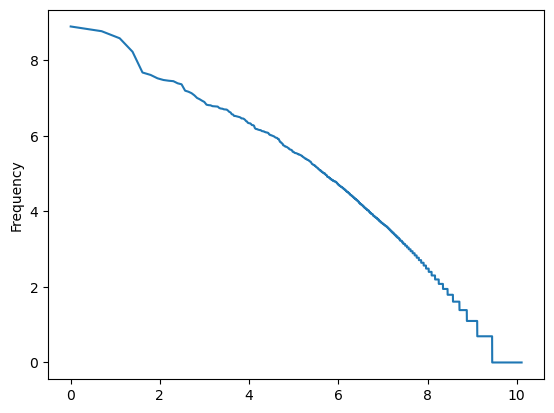

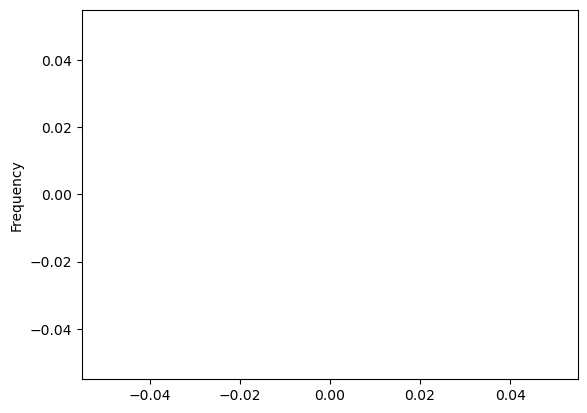

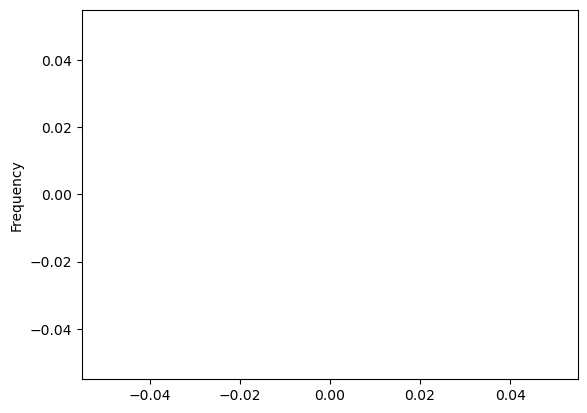

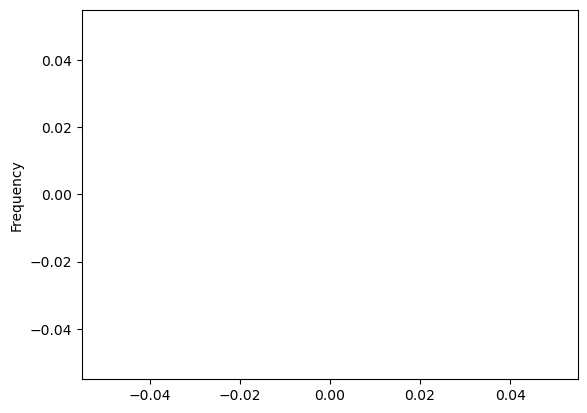

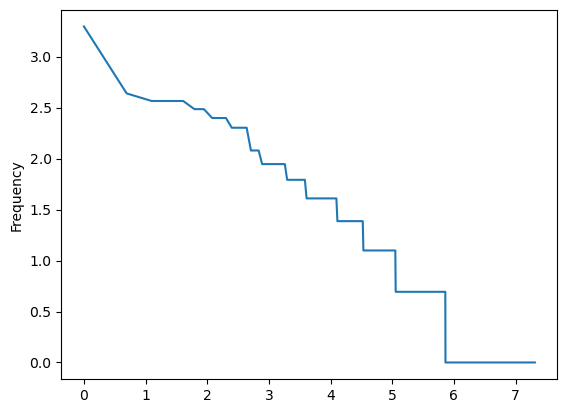

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from nltk import FreqDist
from scipy.stats import linregress

def zipfs_law_fitting_nltk(categ_dict):
    for key, value in categ_dict.items():
        freq_list = []
        all_words = value["all_words"]
        C = len(all_words) / 10
        X_Y_list = [list(range(1, len(all_words) + 1)), [0 for i in range(1, len(all_words) + 1)]] 
        for index in X_Y_list[0]:
            X_Y_list[1][index-1] =  (all_words[index-1][1])
        plt.plot(np.log(X_Y_list[0]), np.log(X_Y_list[1]))
        plt.ylabel('Frequency')
        plt.show()
            
zipfs_law_fitting_nltk(categ_dict)
